In [1]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev

In [2]:
def phase_fit(phi, A, B, C, phi_0):
    return A * np.cos(phi - phi_0) +  B * phi + C

def get_phase_fitter(phases, heights, height_errs):
    fitter = Fitter(phase_fit)
    fitter.set_data(phases, heights, height_errs)
    fitter.set_bounds("A", 0, np.inf)

    # setting this bound makes weird fits for certain phi_0's because they want to fit to a value outside the bound
    # fitter.set_bounds("phi_0", 0, 2*np.pi)
    fitter.fit()
    return fitter


In [3]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [4]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    detunings_MHz = header["detunings"].to("MHz").magnitude
    transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
    monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
    normalized_avg = {}
    for kk in transmissions_avg:
        if transmissions_avg[kk].ndim >= 1:
            normalized_avg[kk] = unumpy.uarray(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
        else:
            normalized_avg[kk] = ufloat(
                transmissions_avg[kk] / monitors_avg[kk],
                np.sqrt(
                    (transmissions_err[kk] / monitors_avg[kk]) ** 2
                    + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                )
            )
    return detunings_MHz, normalized_avg, header

In [5]:
def rf_spectroscopy(data_numbers, scan_string, rforlf):
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    for ll, (label, data_range) in enumerate(data_numbers.items()):
        
        xs_dup = []
        ys_dup = []
        
        for data_number in range(data_range[0], data_range[1]+1):
            
            # GET DATA
            detunings, data, header = get_normalized_transmission(data_number)
    
            # DETUNINGS X-AXIS AND NORMALIZED TRANSMISSION Y-AXIS (DUPLICATE)
            xs_dup.append(header["params"][rforlf][scan_string].magnitude)
            ys_dup.append((data["2"][0]/data["1"][0]).nominal_value)
    
        # REMOVE DUPLICATE IN X-AXIS, AVERAGE ON Y-AXIS
        xs = list(set(xs_dup))
        N = [len([i for j,i in enumerate(xs_dup) if i==x]) for x in xs] # num of each duplicate
        ys = [np.average([ys_dup[i] for i in range(len(ys_dup)) if xs_dup[i] == xs[j]]) for j in range(len(xs))]
        ys_err = [np.std([ys_dup[i] for i in range(len(ys_dup)) if xs_dup[i] == xs[j]])/np.sqrt(N[j]) for j in range(len(xs))]
        
        ax.errorbar(xs, ys, ys_err, ls="", marker=".", label = label)
    
    if ll > 0:
        ax.legend()
    if scan_string == "this_detuning":  
        ax.set_xlabel("Detuning (kHz)")
    elif scan_string == "this_duration":
        ax.set_xlabel("Duration (ms)")
    ax.set_ylabel("Normalized transmission (V/V)")
    plt.show()

In [6]:
plt.close('all')

## High frequency spectroscopy

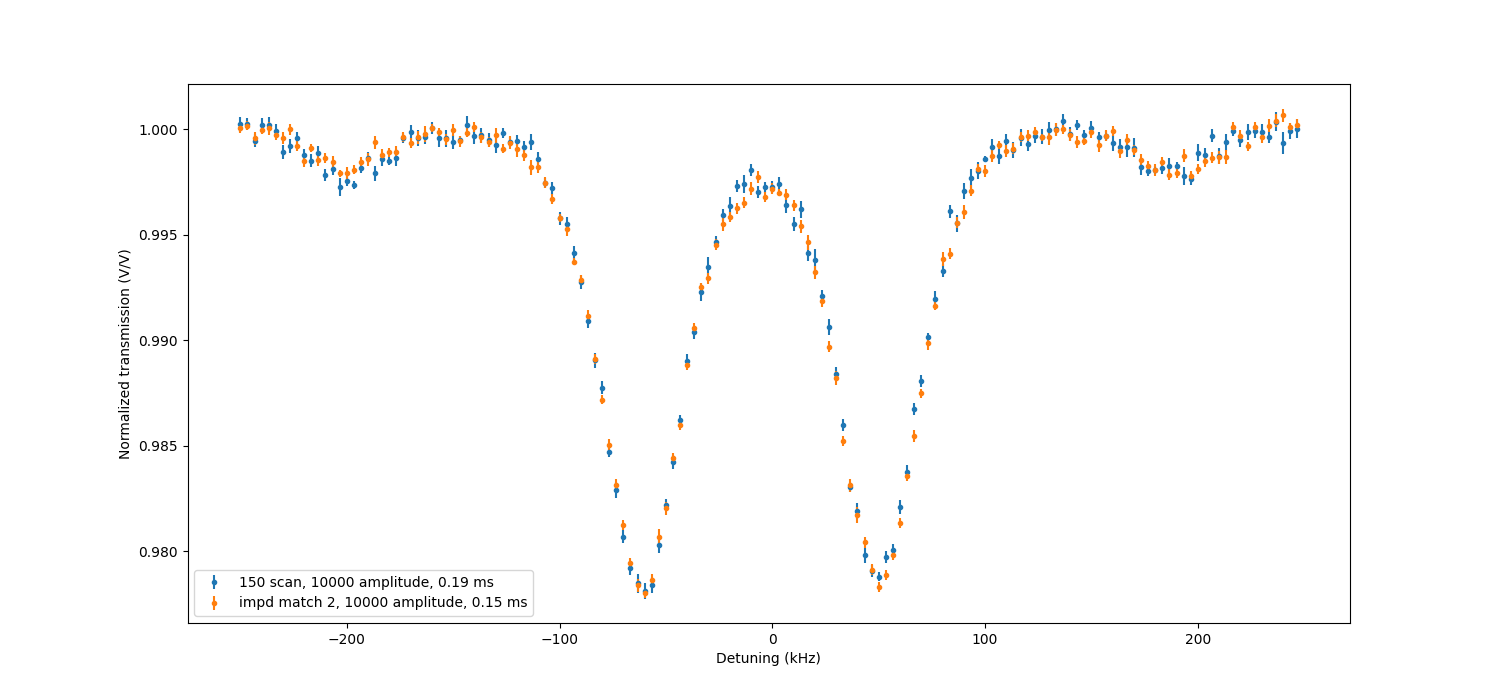

In [7]:
data_numbers = {
    # "old (with bad impedance matching)": (1996001, 1996450),
    # "new": (1996642, 1996691),
    
    # "July 29 - no setpoint (~ 5 K)": (1996801, 2000750),
    # "July 31 - 6.7 K point": (2301713, 2302426),
    # "July 31 - no setpoint again (< 6 K)": (2302548, 2303582),

    
    "150 scan, 10000 amplitude, 0.19 ms": (2307226, 2309347),
    # "impd match 1, 10000 amplitude, 0.15 time": (2312290, 2314770),
    "impd match 2, 10000 amplitude, 0.15 ms": (2318874, 2322076),

    
    # "July 31 - setpoint again 2nd time after some time": (2348118, 2348407),
    

}
rf_spectroscopy(data_numbers, "this_detuning", "rf")

## High frequency Rabi flopping

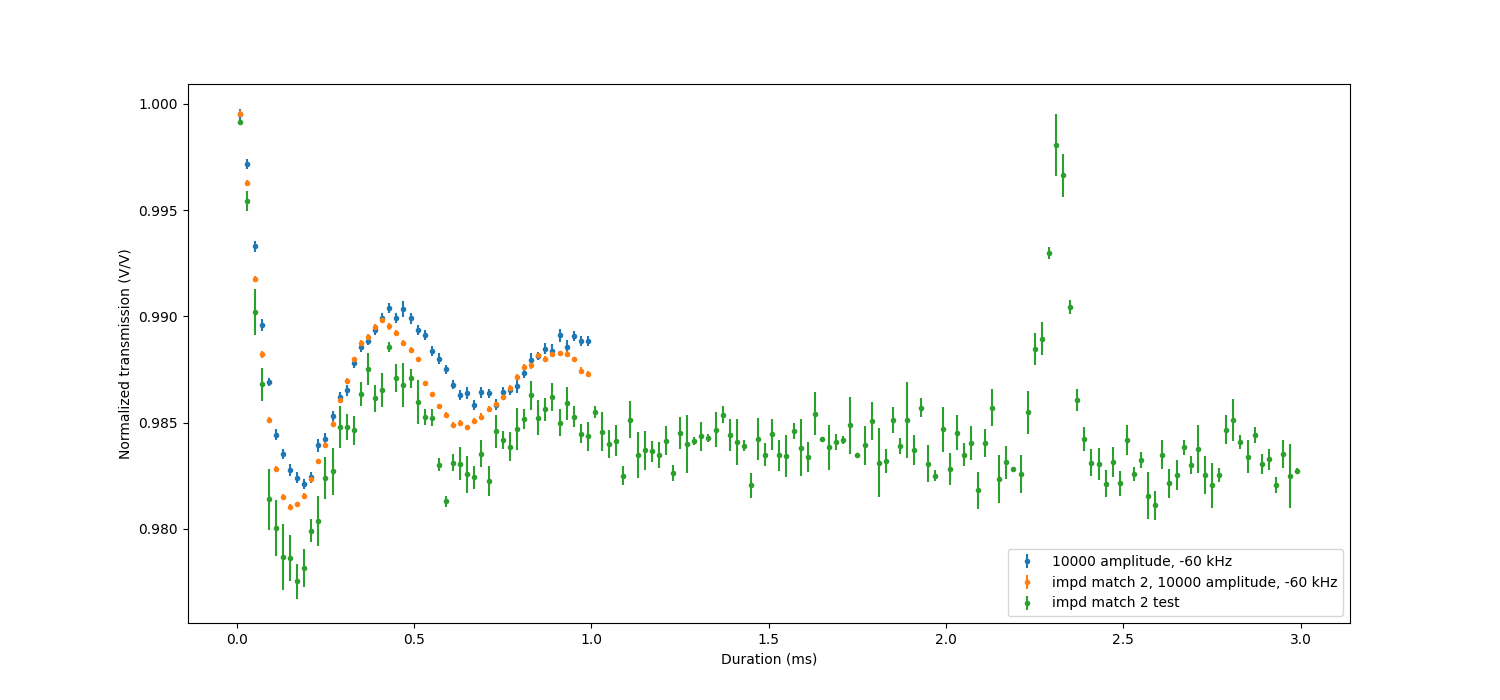

In [8]:
data_numbers = {

    # setpoint was 6.7 K no signal !
    # "-60 kHz, 0 - 2.5 ms ": (2295566, 2296732),
    # # "-60 kHz, 0 - 0.5 ms": (2296950, 2297420),
    # # "-60 kHz, 0 - 5 ms, 50 cb 50 ac": (2297895, 2298505),
    # # "-60 kHz, 0 - 5 ms, 50 cb 50 ac - 3875 amp": (2298583, 2299331),
    # # "-60 kHz, 0 - 5 ms, 50 cb 50 ac - 10000 amp": (2299372, 2299546),
    # # "-60 kHz, 0 - 4 ms, 50 cb 50 ac - 10000 amp": (2299547, 2299920),
    # "-60 kHz, 0 - 4 ms, 50 cb 50 ac - 10000 amp": (2299991, 2301066),


    # "CTC setpoint on (6.7 K)": (2297453, 2297800), # -60 kHz, 0 - 1 ms, 50 cb 50 ac
    # "CTC setpoint off (< 6 K)": (2303899, 2305622), #8000 amplitude, -60 kHz detuning

    ## good stuff
    # "8000 amplitude, -60 kHz": (2303899, 2305622),
    "10000 amplitude, -60 kHz": (2305624, 2307000),
    # "impd match 1, 10000 amplitude, -60 kHz": (2309349, 2312257), # (parallel LC in series w/ resonator)
    "impd match 2, 10000 amplitude, -60 kHz": (2314771, 2318872), # (parallel LC in series w/ (resonator || series LC))

    "impd match 2 test": (2426977, 2427490)
}

rf_spectroscopy(data_numbers, "this_duration", "rf")

## Low frequency spectroscopy b

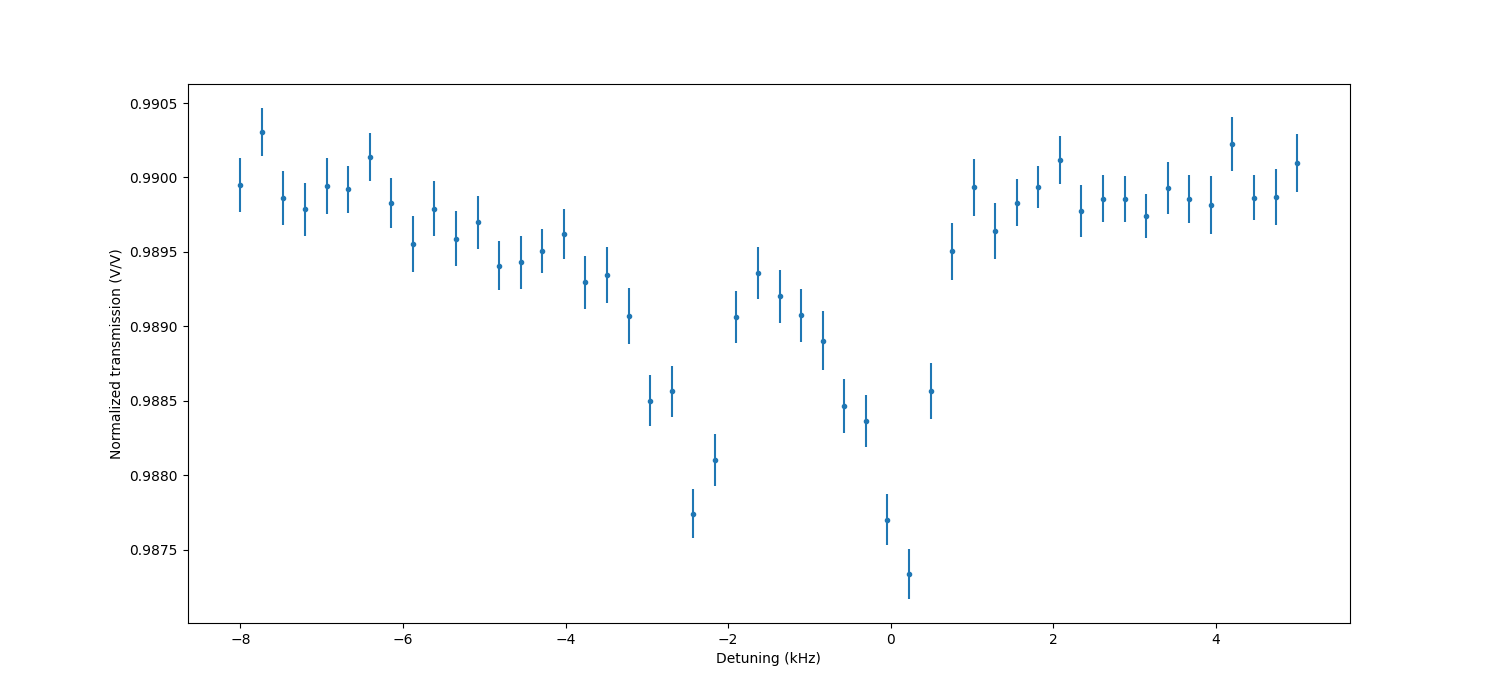

In [80]:
data_numbers = {
    # "hf HSH, lf uses long pulse": (2331271, 2332094),
    # "hf HSH, lf long pulse, denser, CTC off,": (2332126, 2332670),
    # "hf HSH, lf long pulse, denserer, CTC off": (2334121, 2334410)


    # "CTC output off": (2334469, 2334583),
    # "CTC output off - 1 ms": (2334604, 2335132),
    
    # "CTC output off - 2 ms": (2335162, 2347272),
    # "CTC output off - 2 ms 2": (2347272-5000, 2347272), # wrong -> this is 10pi pulse
    # "CTC output on - 2 ms": (2347311, 2347960), # wrong -> this is 10pi pulse


    # "100 - 0.5 ms": (2615646, 2616453)
    "30 - 2 ms": (2616537, 2620048),
}

rf_spectroscopy(data_numbers, "this_detuning", "lf")

## Low frequency Rabi flopping b

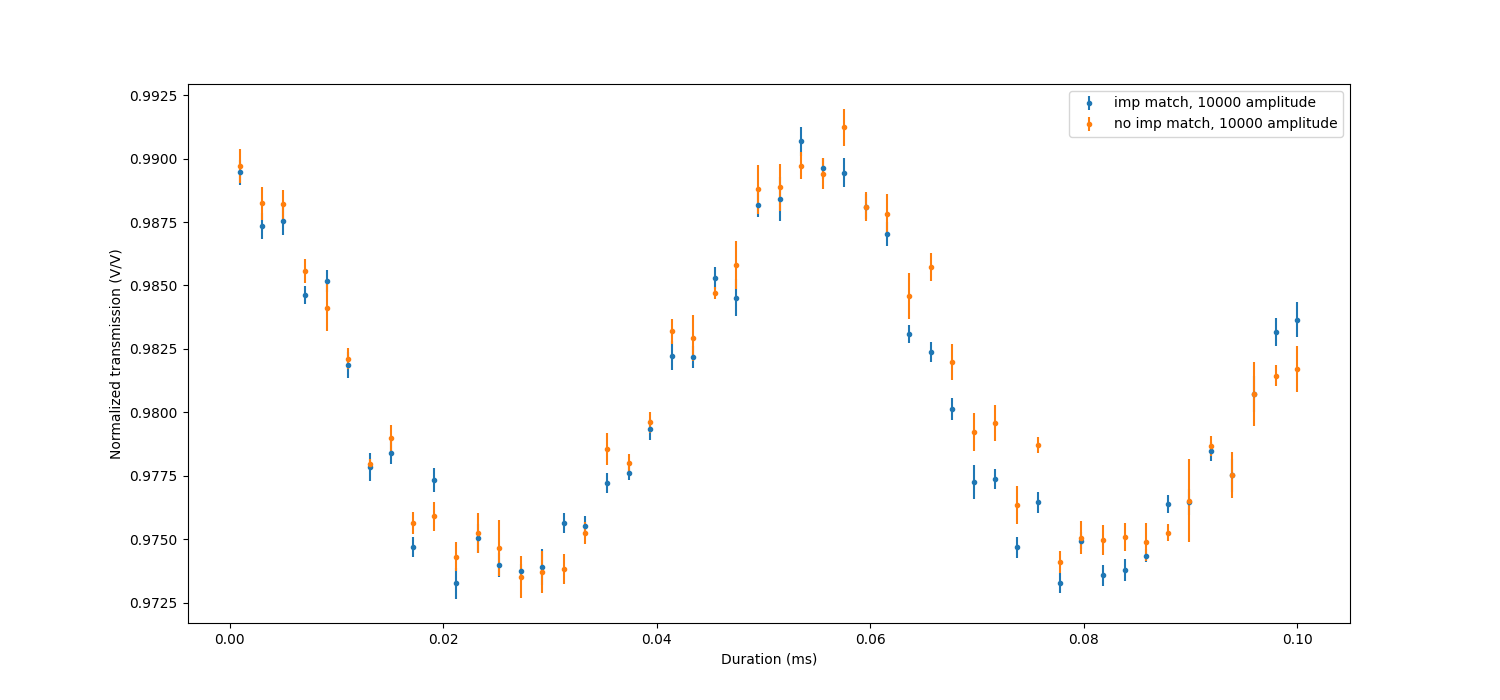

In [91]:
data_numbers = {
    # "hf imp match, 5000 amplitude, 0 detuning": (2323756, 2325730),
    # "hf imp match, 1000 amplitude, 0 detuning": (2325732, 2327509),
    # "hf imp match, 500 amplitude,  0 detuning": (2327510, 2329073), 
    # "hf imp match, 100 amplitude,  0 detuning no HSH": (2329269, 2330290), 
    # "hf imp match, 100 amplitude,  0 detuning HSH": (2330434, 2331194), 

    "imp match, 10000 amplitude": (2620049, 2620556),
    "no imp match, 10000 amplitude": (2620557, 2620750), 

    
}

rf_spectroscopy(data_numbers, "this_duration", "lf")

## Low frequency spectroscopy a

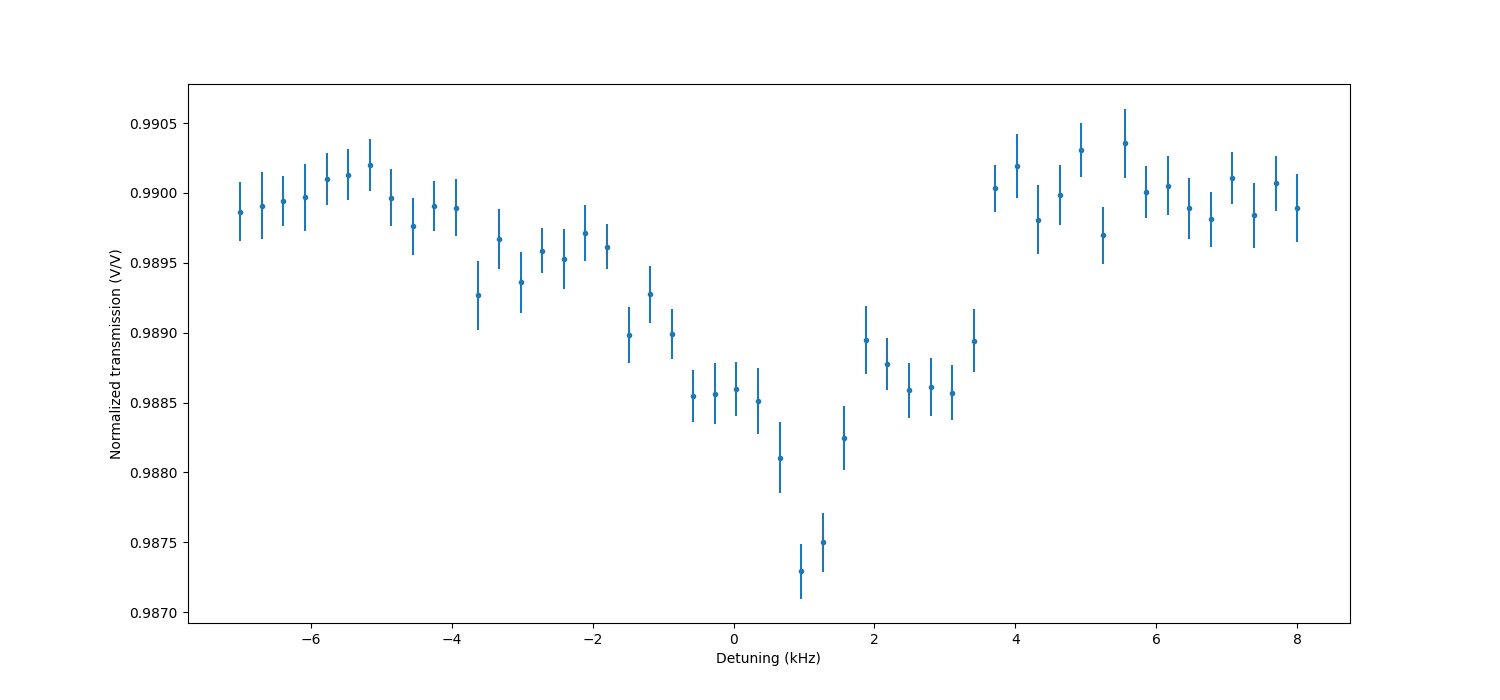

In [63]:
data_numbers = {
    # "HSH - aabar - 2000 ": (2611162, 2611411),
    # "1000 - 0.5 ms": (2612557, 2612839),
    "250 - 1.5 ms": (2612910, 2615538)
}

rf_spectroscopy(data_numbers, "this_detuning", "lf")

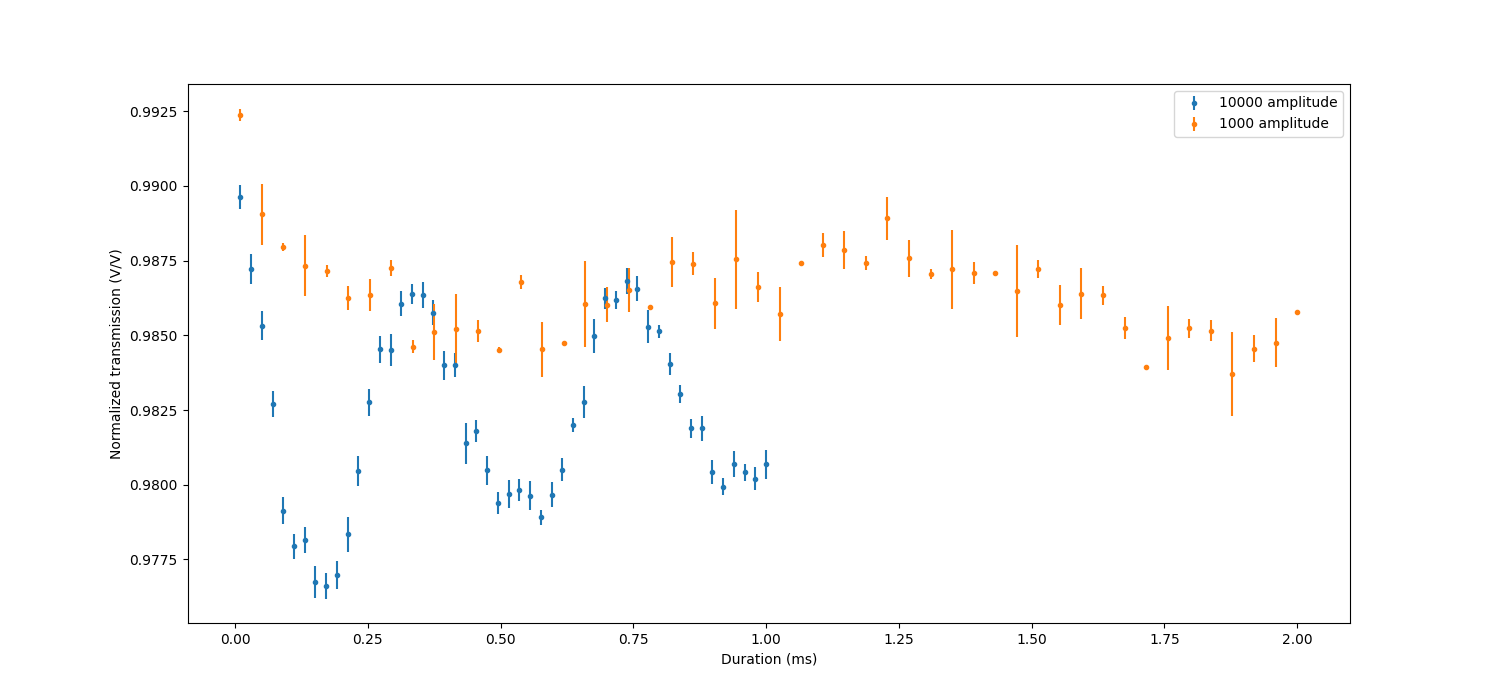

In [79]:
data_numbers = {
    # "2000 amplitude": (2611439, 2611612),
    "10000 amplitude": (2611638, 2612137),
    "1000 amplitude" : (2612427, 2612525),
    # "500 amplitude": (2612370, 2612400),
}

rf_spectroscopy(data_numbers, "this_duration", "lf")

## HSH scan

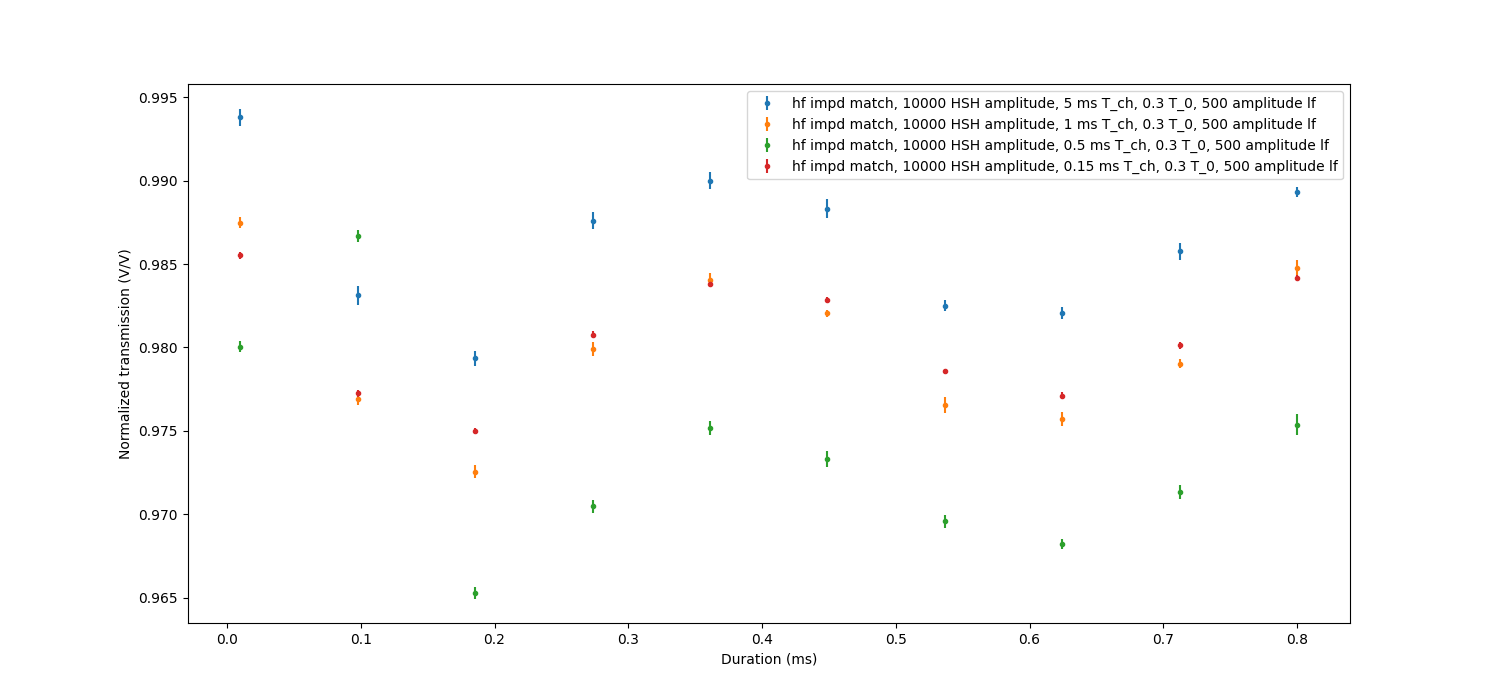

In [102]:
data_numbers = {
    # "hf impd match, 10000 HSH amplitude, 10 ms T_ch, 0.3 T_0, 500 amplitude lf": (2332720, 2332860),
    "hf impd match, 10000 HSH amplitude, 5 ms T_ch, 0.3 T_0, 500 amplitude lf": (2332882, 2332957),
    "hf impd match, 10000 HSH amplitude, 1 ms T_ch, 0.3 T_0, 500 amplitude lf": (2333006, 2333132),
    "hf impd match, 10000 HSH amplitude, 0.5 ms T_ch, 0.3 T_0, 500 amplitude lf": (2333171, 2333278),
    "hf impd match, 10000 HSH amplitude, 0.15 ms T_ch, 0.3 T_0, 500 amplitude lf": (2333280, 2333788),
}

rf_spectroscopy(data_numbers, "this_duration", "lf")

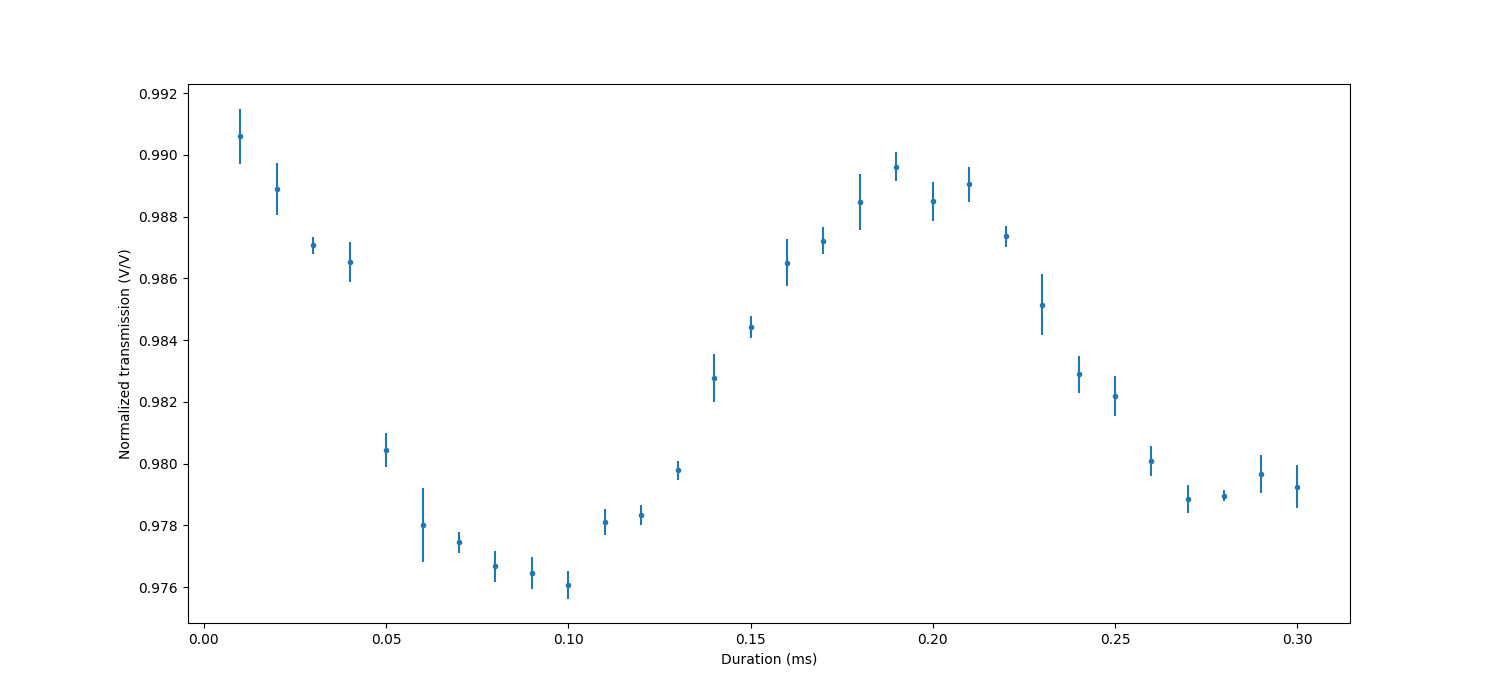

In [32]:
data_numbers = {
    # "no impedance matching"
    "1": (2424118, 2424260), 
}

rf_spectroscopy(data_numbers, "this_duration", "lf")